# Stock Analysis
## Stock Plotting

Plotting CandleStick, Volume, desired Moving Averages, 


In [1]:
import os
import numpy as np
import pandas as pd
import pandas.io.data
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.finance import candlestick
from matplotlib.dates import date2num
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 10})

In [80]:
stocks_to_pull = 'AAPL', 'TSLA', 'EBAY', 'NKE', 'LULU'

def pullData(stock, endYear):
    print 'Currently Pulling', stock
    print str(datetime.datetime.fromtimestamp(int(time.time())).strftime('%Y-%m-%d %H:%M:%S'))
    df = pandas.io.data.get_data_yahoo(stock, 
        start = datetime.datetime(endYear, 1, 1),
        end = datetime.datetime.now())
    df.to_csv('stocks/' + stock + '.csv')

In [81]:
for stock in stocks_to_pull:
    pullData(stock, 2014)

Currently Pulling AAPL
2016-01-22 11:11:07
Currently Pulling TSLA
2016-01-22 11:11:08
Currently Pulling EBAY
2016-01-22 11:11:09
Currently Pulling NKE
2016-01-22 11:11:10
Currently Pulling LULU
2016-01-22 11:11:11


In [42]:
def movingAverages(values, window):
    return pd.rolling_mean(values, window)


def rsiFunction(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)
    for i in range(n, len(prices)):
        delta = deltas[i-1] 
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n
        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi


def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a


def computeMACD(x, slow=26, fast=12):
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow

In [93]:
def graphData(stock_symbol, MA1, MA2):
    # read in df 
    base_dir = 'stocks'
    stockFile = os.path.join(base_dir, stock_symbol + '.csv')
    stock = pd.read_csv(stockFile)
    # convert datetime
    stock['Date'] = pd.to_datetime(stock.Date)
    stock.Date = mdates.date2num(stock.Date.dt.to_pydatetime())

    date, closep, highp, lowp, openp, volume = \
    stock['Date'], stock['Open'], stock['High'], stock['Low'], stock['Adj Close'], stock['Volume']
    
    # get moving averages
    av1 = movingAverages(closep, MA1)
    av2 = movingAverages(closep, MA2)
    
    # cut out non data
    sp = len(date[MA2 - 1:])
    
    # fill candlestick array
    x = 0
    y = len(date)
    candleArray = []
    while x < y:
        appendLine = date[x], openp[x], closep[x], highp[x], lowp[x], volume[x]
        candleArray.append(appendLine)
        x += 1   

    fig = plt.figure(facecolor='#07000d', figsize=(18,6))
    
    ax1 = plt.subplot2grid((6,4), (1,0), rowspan = 4, colspan = 4, axisbg='#07000d')
    # plot candlestick
    candlestick(ax1, candleArray[-sp:], width = 1, colorup = '#53c156', colordown = '#ff1717')
    # plot moving averages
    ax1.plot(date[-sp:], av1[-sp:], '#e1edf9', label = '{} SMA'.format(MA1), linewidth = 1.5)
    ax1.plot(date[-sp:], av2[-sp:], '#4ee6fd', label = '{} SMA'.format(MA2), linewidth = 1.5)
    # plot params 
    ax1.grid(True, color = 'w')
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune = 'upper'))
    ax1.yaxis.label.set_color('w')
    ax1.spines['bottom'].set_color('#5998ff')
    ax1.spines['top'].set_color('#5998ff')
    ax1.spines['left'].set_color('#5998ff')
    ax1.spines['right'].set_color('#5998ff')
    ax1.tick_params(axis = 'y', colors = 'w')
    ax1.tick_params(axis = 'x', colors = 'w')
    plt.ylabel('Stock Price and Volume')
    # format legend
    maLeg = plt.legend(loc = 9, ncol = 2, prop = {'size': 8}, fancybox = True)
    maLeg.get_frame().set_alpha(0.4)
    textEd = plt.gca().get_legend().get_texts()
    plt.setp(textEd[0:5], color = 'w')
    
    ax0 = plt.subplot2grid((6,4), (0,0), sharex = ax1, rowspan = 1, colspan = 4, axisbg='#07000d')
    # rsi plot
    rsiCol = '#c1f9f7'
    posCol = '#386d13'
    negCol = '#8f2020'
    rsi = rsiFunction(closep)
    ax0.plot(date[-sp:], rsi[-sp:], color = rsiCol, linewidth = 1.5)
    ax0.axhline(70, color = negCol)
    ax0.axhline(30, color = posCol)
    ax0.fill_between(date[-sp:], rsi[-sp:], 70, where = (rsi[-sp:] >= 70), facecolor = negCol, 
                     edgecolor = negCol, alpha = 0.5)
    ax0.fill_between(date[-sp:], rsi[-sp:], 30, where = (rsi[-sp:] <= 30), facecolor = posCol, 
                     edgecolor = posCol, alpha = 0.5)
    ax0.spines['bottom'].set_color('#5998ff')
    ax0.spines['top'].set_color('#5998ff')
    ax0.spines['left'].set_color('#5998ff')
    ax0.spines['right'].set_color('#5998ff')
    ax0.tick_params(axis = 'y', colors = 'w')
    ax0.tick_params(axis = 'x', colors = 'w')
    ax0.set_yticks([30, 70])
    ax0.text(0.015, 0.95, 'RSI(14)', va = 'top', color = 'w', transform = ax0.transAxes)
    ax0.yaxis.label.set_color('w')
    ax0.grid(False)
    
    # volume plot
    ax1v = ax1.twinx()
    ax1v.fill_between(date[-sp:], 0, volume[-sp:], facecolor = '#00ffe8', alpha = 0.5)
    ax1v.grid(False)
    ax1v.axes.yaxis.set_ticklabels([])
    ax1v.spines['bottom'].set_color('#5998ff')
    ax1v.spines['top'].set_color('#5998ff')
    ax1v.spines['left'].set_color('#5998ff')
    ax1v.spines['right'].set_color('#5998ff')
    ax1v.set_ylim(0, 3 * volume.max())
    ax1v.tick_params(axis = 'y', colors = 'w')
    ax1v.tick_params(axis = 'x', colors = 'w')
    
    # MACD plot
    ax2 = plt.subplot2grid((6,4), (5,0), sharex = ax1, rowspan = 1, colspan = 4, axisbg='#07000d')
    nslow = 26
    nfast = 12
    nema = 9
    emaslow, emafast, macd = computeMACD(closep)
    ema9 = ExpMovingAverage(macd, nema)
    
    ax2.plot(date[-sp:], macd[-sp:], color = '#4ee6fd', lw = 2)
    ax2.plot(date[-sp:], ema9[-sp:], color = '#e1edf9', lw = 1)
    ax2.text(0.015, 0.95, 'MACD (12, 26, 9)', va = 'top', color = 'w', transform = ax2.transAxes)
    ax2.fill_between(date[-sp:], macd[-sp:] - ema9[-sp:], 0, alpha = 0.5, facecolor = '#00ffe8', edgecolor = '#00ffe8')
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune = 'upper'))
    
    ax2.spines['bottom'].set_color('#5998ff')
    ax2.spines['top'].set_color('#5998ff')
    ax2.spines['left'].set_color('#5998ff')
    ax2.spines['right'].set_color('#5998ff')
    ax2.tick_params(axis = 'y', colors = 'w')
    ax2.tick_params(axis = 'x', colors = 'w')
    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
    plt.xticks(rotation = 45)
    
#     ax1.annotate('Big news!',(date[510],av1[510]),
#             xytext=(0.8, 0.9), textcoords='axes fraction',
#             arrowprops=dict(facecolor='white', shrink=0.05),
#             fontsize=14, color = 'w',
#             horizontalalignment='right', verticalalignment='bottom')
    
    plt.setp(ax0.get_xticklabels(), visible = False)
    plt.setp(ax1.get_xticklabels(), visible = False)
    plt.suptitle('{}'.format(stock_symbol), size = 20, color = 'w')
    plt.subplots_adjust(hspace = 0)
    plt.show()
#     fig.savefig('example.png',facecolor=fig.get_facecolor())

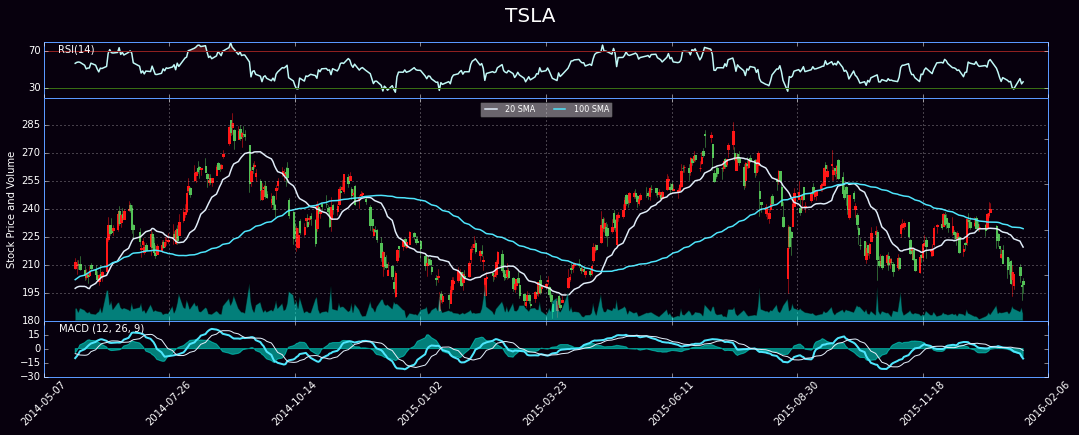

In [94]:
graphData('TSLA', 20, 100) 

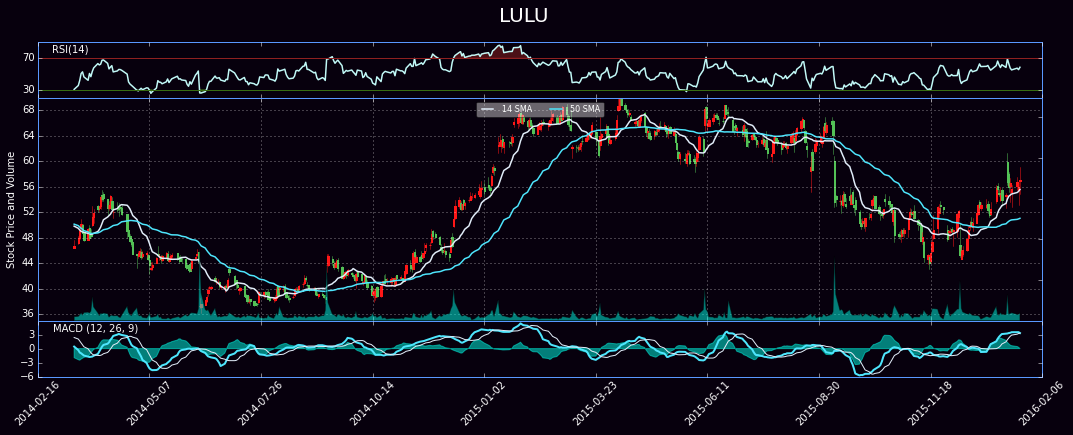

In [97]:
graphData('LULU', 14, 50)